# 2019 2nd ML month with KaKR
# House Price Prediction

캐글 대회 참여하기 👉 [클릭](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/overview)

## 목차
1. 데이터 탐색
- 1) 문제 정의
- 2) 변수 설명
- 3) 데이터 개요 확인
2. 데이터 전처리
- 1) id, date 변수 정리
- 2) 결측치 확인
- 3) 변수들 분포를 로그 변환
- 4) Target Data: 집 가격 (data[price])
    - 왜도
    - 첨도
3. 모델링
- 1) RMSE
- 2) 네 가지 모델
- 3) 그리드 탐색
4. 잔차 분석

In [70]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mlp
mlp.rcParams['font.family'] = 'NanumGothic'

In [71]:
# Data 경로 지정
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

# Data 불러오기
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 1. 데이터 탐색

### 1) 문제 정의
이번 데이터의 목적은 집의 정보를 갖고 가격을 예측하는 회귀문제입니다.<br>
평가는 RMSE(Root Mean Squared Error) 방식으로 이뤄지고,<br>
제공되는 File 등은 trian.csv, test.csv, sample_submission.csv 파일입니다.

### 2) 변수 설명
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 3) 데이터 개요 확인

In [72]:
# Data shape 확인
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


- 훈련/평가 데이터 크기는 15,035, 6,468개로 약 5:2의 비율로 불균형한 데이터로 보기는 어렵다!
- 변수의 개수가 20, 21개의 차이는 target이 되는 데이터 y가 train에 포함되어 있기 때문. 참고로 집값 예측이기 때문에 target data는 'price'이다. 

In [73]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [74]:
train_len = len(train)
print("train 크기:", train_len)

train 크기: 15035


In [75]:
test_len = len(test)
print("train 크기:", test_len)

train 크기: 6468


# 2. 데이터 전처리 
- 각 변수들에 대해 결측 유무를 확인
- 분포를 확인해보면서 간단하게 전처리 진행

### 1) id, date 변수 정리
- id 변수는 모델의 집값 예측에 아무 영향이 없으므로 삭제
- 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장
- date 변수는 '20141013T000000' 형식, 연월까지만 고려하는 범주형 번수로 변경

In [76]:
# price Data를 y에 저장하고, 'price'는 삭제하기
# id 데이터는 
y = train['price']
del train['price']
del train['id']

print("컬럼 종류")
for i in range(len(train.columns)):
    print(i+1, train.columns[i])

컬럼 종류
1 date
2 bedrooms
3 bathrooms
4 sqft_living
5 sqft_lot
6 floors
7 waterfront
8 view
9 condition
10 grade
11 sqft_above
12 sqft_basement
13 yr_built
14 yr_renovated
15 zipcode
16 lat
17 long
18 sqft_living15
19 sqft_lot15


In [77]:
# date 컬럼의 날짜를 년도+월 까지 정수형으로 변환
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [78]:
# test data에도 동일하게 적용해줍니다.
# 대신 test data에는 target column인 'price'가 없습니다!

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print("컬럼 종류")
for i in range(len(test.columns)):
    print(i+1, test.columns[i])

컬럼 종류
1 date
2 bedrooms
3 bathrooms
4 sqft_living
5 sqft_lot
6 floors
7 waterfront
8 view
9 condition
10 grade
11 sqft_above
12 sqft_basement
13 yr_built
14 yr_renovated
15 zipcode
16 lat
17 long
18 sqft_living15
19 sqft_lot15


In [79]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [80]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [81]:
# train, test Data를 합쳐서 data 변수명에 저장
data = pd.concat((train, test), axis=0)

print("train, test 합친 데이터 크기:" , len(data))

train, test 합친 데이터 크기: 21503


In [82]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2) 결측치 확인
- 데이터에 결측치 있는지 확인
- missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있음

<AxesSubplot:>

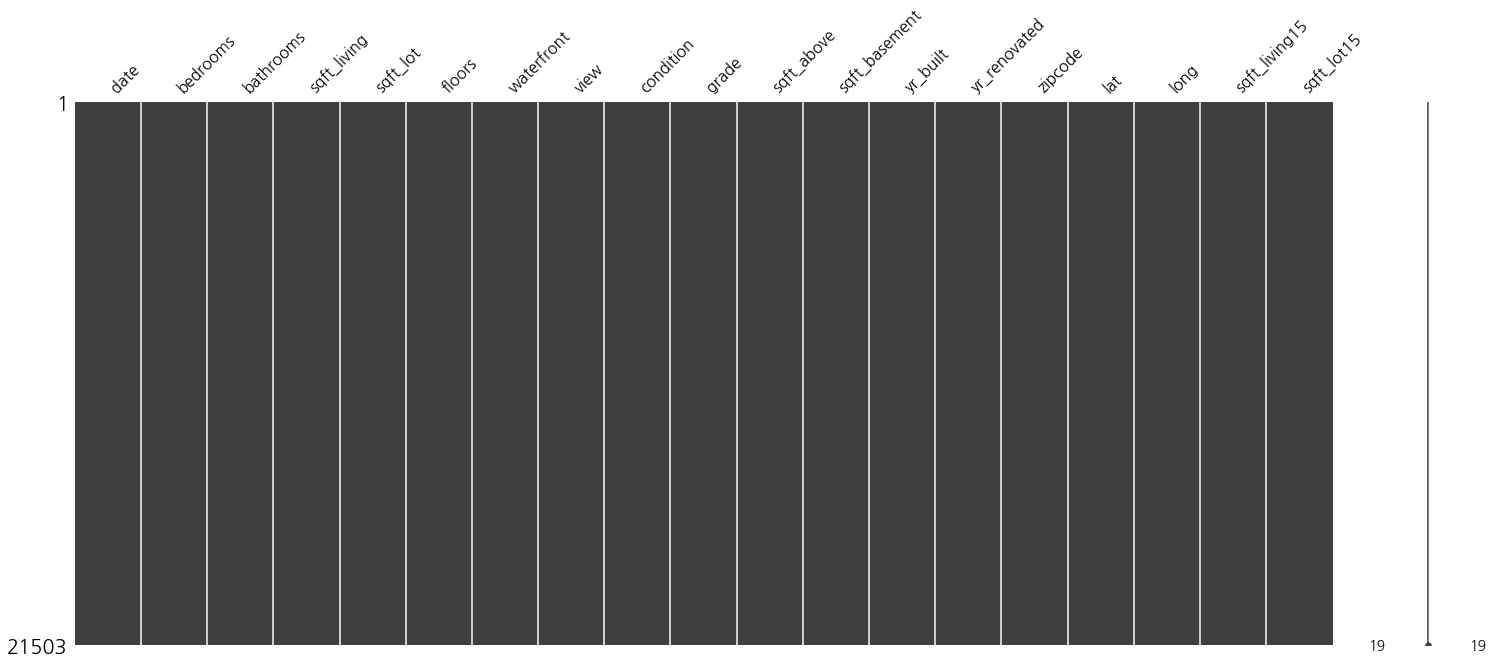

In [83]:
msno.matrix(data)

In [84]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [85]:
# 혹시 모르니 결측치가 있는지 헌 번 더 확인하기

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


결측치는 없습니다.

### 3) 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

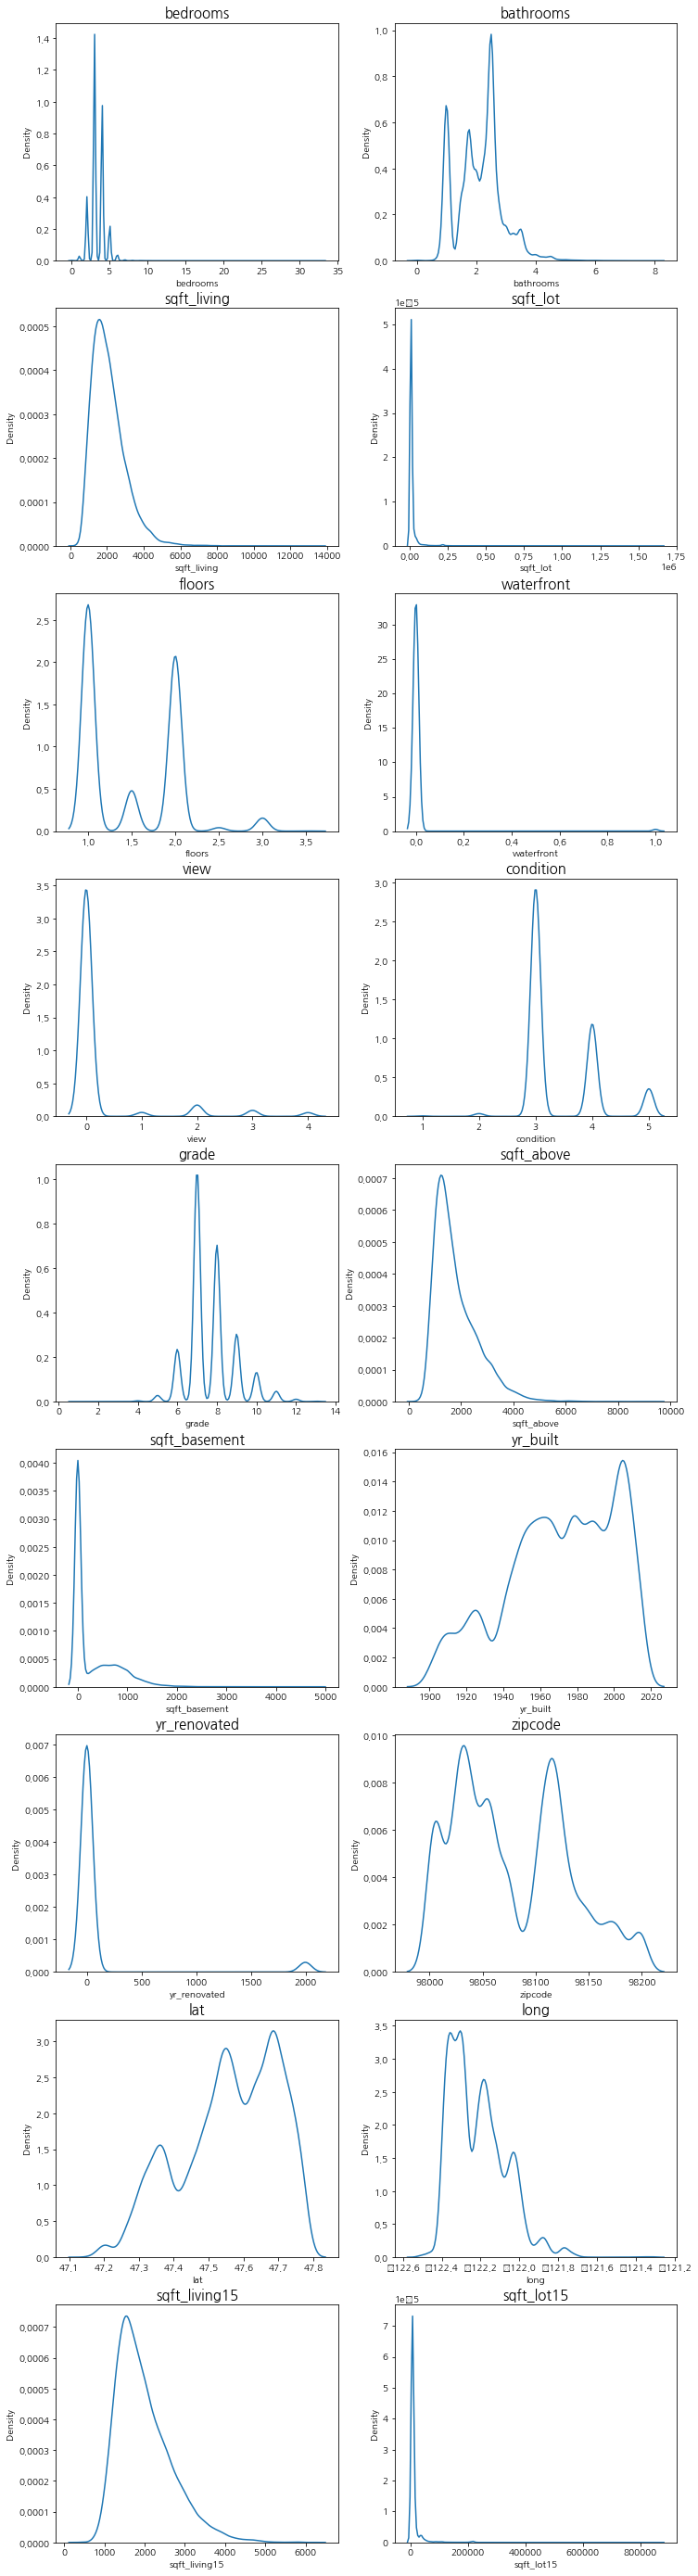

In [87]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 
# 9x2 행 그래프, 가로x세로 사이즈 (12, 50)
# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.

count = 1
columns = data.columns

for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

- 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement' 변수가 한쪽으로 치우친 경향을 보임
- 이 변수들을 log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 주는 작업

In [88]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

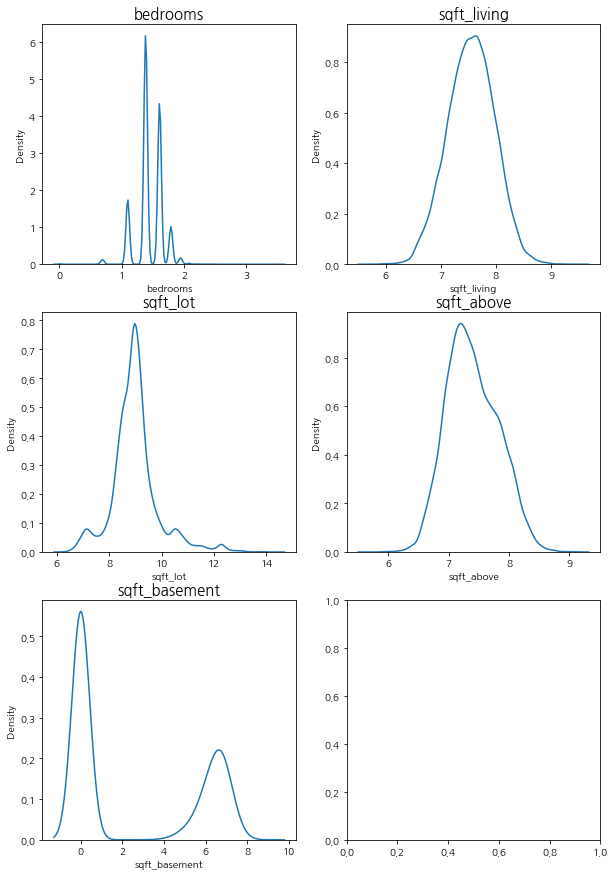

In [89]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

### 여기서 들었던 의문
'view', 'waterfront', 'sqft_lot15' 의 경우도 데이터가 한쪽으로 치우쳐져 있는 모양인데 왜 위의 5개 변수만 로그 스케일링 변환을 시도할까?

- 원래 데이터가 로그 정규 분포를 따르거나 대략 따라야한다. 그렇지 않으면 로그 변환이 작동하지 않는다.

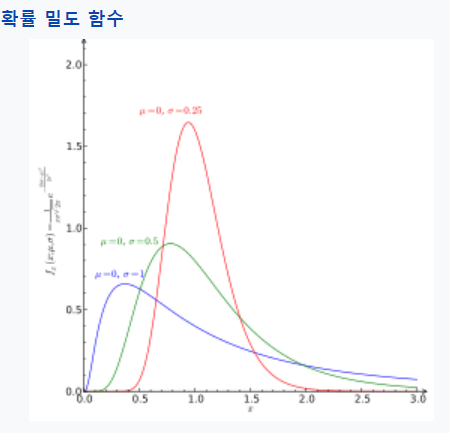

### 4) Target Data y : 집 가격 (data[price]) 확인
- 가격의 분포를 로그 변환했을 때 결과를 유추해봅시다.

In [90]:
# target data 분포도 확인
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

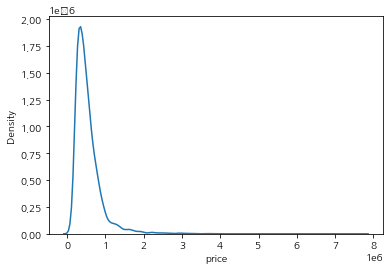

In [91]:
sns.kdeplot(y)
plt.show()

- 로그 변환시, 0쪽으로 매우 심하게 치우쳐져 있는 분포를 보임
- 0과 1,000,000 사이에 대부분의 값이 몰려 있고, 아주 소수의 집들이 굉장히 높은 가격을 보인다.
- 따라서 이 분포에 **로그 변환**을 취하면, 0에 가깝게 몰려 있는 데이터들은 넓게 퍼지고, 소수의 데이터들은 작은 y 값으로 모일 것이다.
- 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고, 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 되므로 전체 분포는 정규분포의 형상을 띄는 방향으로 변환될 것이다.

### - 왜도(skewness) 확인
- 왜도란 확률 분포의 비대칭성을 나타내는 지표이다. 값이 양수일 경우, 분포가 왼쪽으로 치우쳐 있고, 값이 음수일 경우 분포가 오른쪽으로 치우쳐 있다.
- 수식으로는
$$ z= [\frac{x-u}{σ}]^3$$
으로 z-score의 3승의 평균 값으로 구할 수 있음

$$ Skewness[y1] = E [\frac{x-u}{σ}]^3$$ 

정규분포나 좌우 대칭인 분포의 왜도값은 0 혹은 0 에 가까운 값을 가집니다.

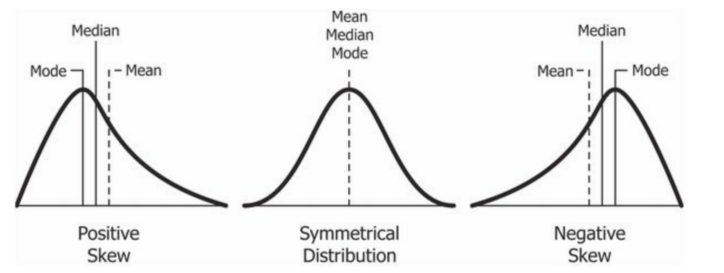
<출처: 위키백과>


### - 첨도(kurtosis) 확인
- 첨도란 확률 분포의 뾰족한 정도를 나타내는 척도로, 관측치들이 얼마만큼 평균에 몰려 있는가를 측정할 때마다 사용됨
- 첨도값이 3에 가까우면 산포도가 정규분포에 가깝다고 볼 수 있으며, 3보다 작을 경우 정규분포보다 완만한, 납작한 분포로 판단할 수 있다.
- 첨도값이 3보다 큰 경우에는 정규분포보다 더 뾰족한 분포로 생각할 수 있음

$$ z= [\frac{x-u}{σ}]^4$$
으로 z-score의 3승의 평균 값으로 구할 수 있음

$$ Kurtosis[k] = E [\frac{x-u}{σ}]^4 = E[z^4] $$ 

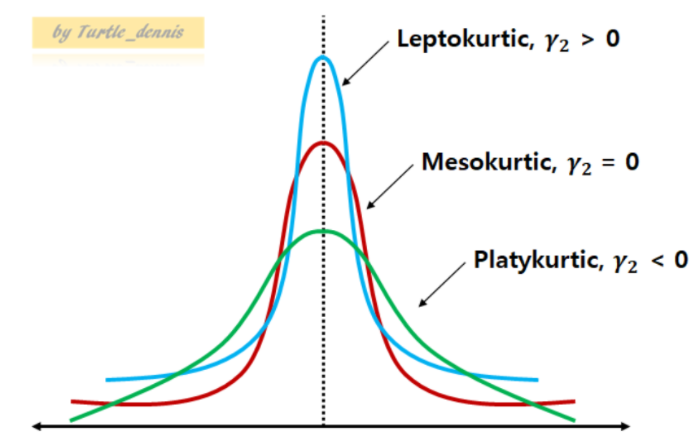

In [92]:
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 4.290252
Kurtosis: 40.154919


- 왜도값이 4.2로 3점이 넘습니다. 위의 그래프와 비교해봐도 데이터가 왼쪽에 분포해 있음을 알 수 있습니다.
- 첨도값이 약 40.15로 상당히 높은 편이며, 이는 한 곳에 데이터가 많이 몰려있음을 다시 한 번 확인 시켜 줍니다.

target 데이터가 굉장히 불균형하기 때문에 회귀분석 시에 분석에 어려움이 예상됩니다! 지금 필요한 건 타겟 데이터를 더 쫙 펼쳐서 고루 분포하게 도와주는 작업입니다.

#### 정규분포화 방법
1. 로그변환: log()
2. 제곱근변환: sqrt()

우리는 이중 **로그변환**을 시켜줄 생각입니다. 

In [93]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

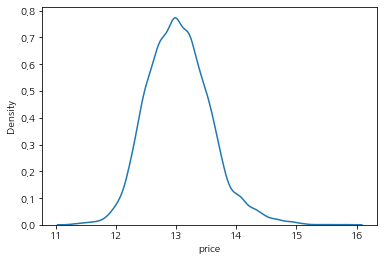

In [94]:
sns.kdeplot(y)
plt.show()

- 아까보다 확실히 데이터가 더 고루 퍼졌다는 걸 확인할 수 있습니다.
- 그래프도 더 넓게 펴지고 정규분포 모양을 띄고 있습니다👏

In [95]:
# 전체 데이터의 자료형을 한눈에 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 3. 모델링

❗ 주의사항: y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다.

### 1) RMSE 계산

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# RMSE 점수를 계산하기 위한 mean_squared_error

In [97]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# exp로 다시 변환하여 mean_squared_error를 계산한 값에 np.sqrt 취하기

### 2) 네 가지 모델 이용

In [98]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델 이용

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [99]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [100]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [101]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y,
                                                        random_state=random_state,
                                                        test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [102]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

### 3) 그리드 탐색

In [103]:
from sklearn.model_selection import GridSearchCV

In [104]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [107]:
model = LGBMRegressor(random_state=random_state)

In [108]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.0s finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [109]:
grid_model.cv_results_

{'mean_fit_time': array([0.07309074, 0.12017612, 0.24059882, 0.36225319]),
 'std_fit_time': array([0.00310795, 0.01135586, 0.01570388, 0.01985335]),
 'mean_score_time': array([0.00534801, 0.01314597, 0.01596131, 0.02611575]),
 'std_score_time': array([8.14129315e-05, 1.02437690e-02, 2.26442392e-03, 3.59487455e-04]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': ar

In [110]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [112]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [113]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [114]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [115]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [116]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [117]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### 4) 제출

In [118]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.7s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [119]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [120]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [121]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [122]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [123]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [124]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [125]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!
